# Train, tune, and deploy a custom ML model using the Time Series Forecasting (CfC) Algorithm from AWS Marketplace

The [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](placeholder) performs time series forecasting with the Closed-Form Continuous-Depth (CfC) network. It implements both training and inference from CSV data and supports both CPU and GPU instances. The training and inference Docker images were built by extending the PyTorch 2.0 Python 3.10 SageMaker containers. The Docker images include software licensed under the [Apache License 2.0](https://github.com/fg-research/cfc-tsf-sagemaker/blob/master/LICENSE.txt).

#### Model Overview  
The closed-form continuous-depth network (CfC) is a new neural network architecture for sequential data. CfCs belong to the class of continuous-time recurrent neural networks (CT-RNN), where the evolution of the hidden state over time is described by an Ordinary Differential Equations (ODE). 

CfCs use the Liquid Time Constant (LTC) ODE, where both the derivative and the time constant of the hidden state are determined by a neural network. Differently from other CT-RNNs (including LTCs), which use a numerical solver to approximate the ODE solution, CfCs use an approximate closed-form solution. As a results, CfCs achieve faster training and inference performance than other CT-RNNs.

The hidden state $x$ of a CfC at time $t$ is given by

$$x(t) = \sigma(-f(x, I; \theta_f)t) \odot g(x, I; \theta_g) + [1 - \sigma(-[f(x, I; \theta_f)]t)] \odot h(x, I; \theta_h)$$

where $\odot$ is the Hadamard product, $\sigma$ is the sigmoid function, $I$ is the input sequence, while $f$, $g$ and $h$ are neural networks. The three neural networks $f$, $g$ and $h$ share a common backbone, which is a stack of fully-connected layers with non-linear activation functions. 

The backbone is followed by three separate neural network heads. The head of the $g$ and $h$ neural networks is a fully-connected layer with hyperbolic tangent activation. The head of the $f$ neural network is an affine function $b + a(\Delta t)$ where $\Delta t$ is the time increment (or time span) between consecutive time steps while the intercept $b$ and slope $a$ are the outputs of two fully-connected layers with linear activation.

<img src=https://fg-research-assets.s3.eu-west-1.amazonaws.com/cfc-diagram.png style="width:100%;margin-top:20px;margin-bottom:20px"/>

*CfC architecture (source: [doi:10.1038/s42256–022–00556–7](https://doi.org/10.1038/s42256-022-00556-7))*

#### Model Resources 
- **Paper:** [Closed-form continuous-time neural networks](https://doi.org/10.1038/s42256-022-00556-7f).

This sample notebook shows you how to train a custom ML model using the [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](placeholder).

**Note: This is a reference notebook and it cannot run unless you make the changes suggested in the notebook.**

## Pre-requisites
1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](placeholder).

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (by using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cfc-tsf-algo-v1-1"

## 2. Prepare dataset

In [2]:
import io
import datetime
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-eu-west-1-661670223746'

In [4]:
# EC2 instance
instance_type = "ml.m5.2xlarge"

In [5]:
# fixed hyperparameters
context_length = 200     # number of timesteps used as input 
prediction_length = 100  # number of timesteps to output

### A. Dataset format expected by the algorithm

The training and validation datasets should be provided as CSV files. 
Each column represents a time series, while each row represents a time step.
All the time series should have the same length and should not contain missing values.
The column headers should be formatted as follows:

- The column names of the (mandatory) target time series should start with `"y"` (e.g. `"y1"`, `"y2"`, ...). 
- The column names of the (optional) feature time series should start with `"x"` (e.g. `"x1"`, `"x2"`, ...). 
- The column containing the time spans (optional) should be named `"ts"`.

If the features are not provided, the algorithm will only use the past values of the target time series as input.      
If the time spans are not provided, the algorithm will assume that the observations are equally spaced.

You can find more information about dataset format in the **Usage Information** section of the algorithm listing page.

### B. Configure and visualize train and test dataset

The sample data provided in the algorithm's [GitHub repository](https://github.com/fg-research/cfc-tsf-sagemaker) consists of four artificially generated time series including two targets ("y1", "y2") and two features ("x1", "x2") observed at equally spaced time intervals ("ts"). The training dataset contains 1000 samples, while the validation and test datasets contain 500 samples. 

**Training dataset:**

In [6]:
training_dataset = pd.read_csv("https://raw.githubusercontent.com/fg-research/cfc-tsf-sagemaker/master/data/training/train.csv")

In [7]:
training_dataset.shape

(1000, 5)

In [8]:
training_dataset.head()

,ts,x1,x2,y1,y2
0,0.0000,0.121642,-0.992107,2.627251,-21.043495
1,0.0005,-0.046251,-0.899425,-3.134639,-20.881941
2,0.0005,0.016789,-0.845949,-3.418829,-16.630003
3,0.0005,-0.020171,-1.000907,-7.383935,-20.160302
4,0.0005,-0.313692,-1.002584,-11.523211,-18.012853


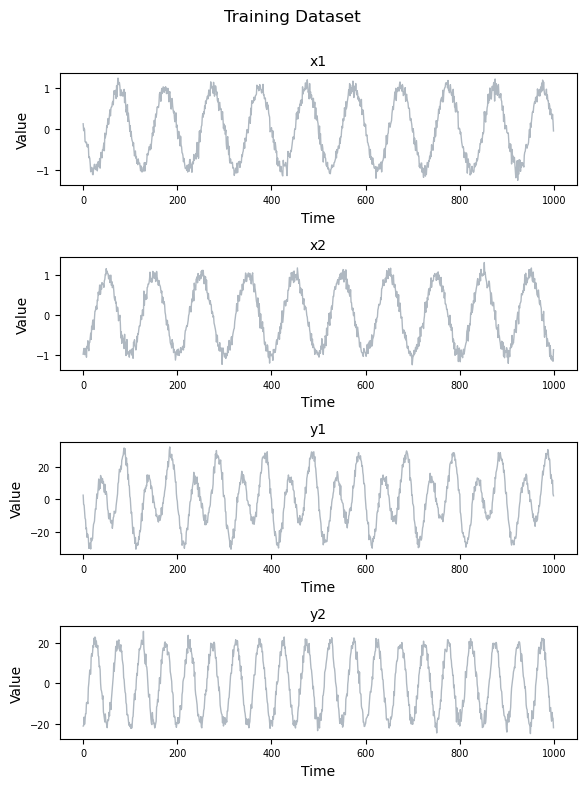

In [9]:
fig, axs = plt.subplots(nrows=len([c for c in training_dataset.columns if c != "ts"]), ncols=1, sharex=True, figsize=(6, 8))
for i, c in enumerate([c for c in training_dataset.columns if c != "ts"]):
    axs[i].plot(training_dataset[c], color="#AFB8C1", lw=1)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

**Validation dataset:**

In [10]:
validation_dataset = pd.read_csv("https://raw.githubusercontent.com/fg-research/cfc-tsf-sagemaker/master/data/training/valid.csv")

In [11]:
validation_dataset.shape

(500, 5)

In [12]:
validation_dataset.head()

,ts,x1,x2,y1,y2
0,0.0005,-0.102191,-1.020255,-1.629867,-18.293319
1,0.0005,-0.196894,-0.825729,-5.875837,-15.153669
2,0.0005,-0.103916,-0.909815,-9.099113,-18.314596
3,0.0005,-0.128711,-1.021893,-10.430847,-17.330995
4,0.0005,-0.331239,-0.987491,-15.354902,-15.939409


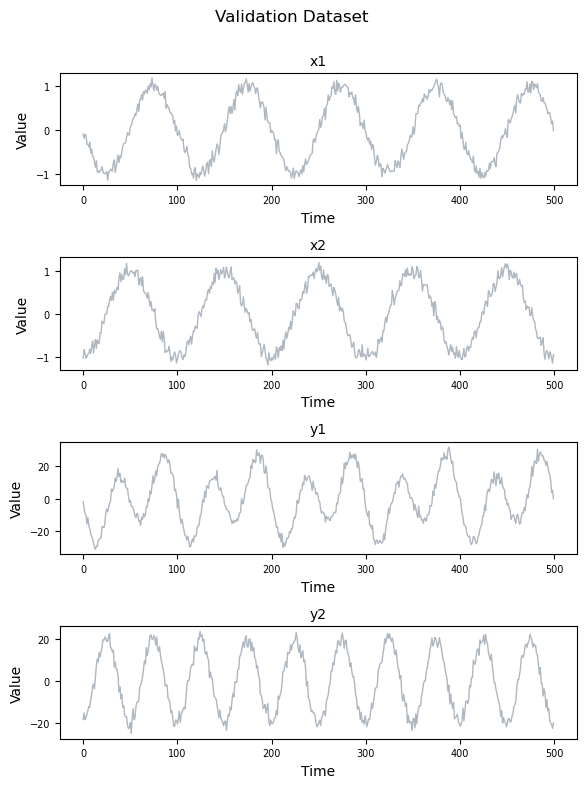

In [13]:
fig, axs = plt.subplots(nrows=len([c for c in validation_dataset.columns if c != "ts"]), ncols=1, sharex=True, figsize=(6, 8))
for i, c in enumerate([c for c in validation_dataset.columns if c != "ts"]):
    axs[i].plot(validation_dataset[c], color="#AFB8C1", lw=1)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Validation Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

### C. Upload datasets to Amazon S3

In [14]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/training/train.csv"
)

In [15]:
training_data

's3://sagemaker-eu-west-1-661670223746/data/training/train.csv'

In [16]:
validation_data = sagemaker_session.upload_string_as_file_body(
    body=validation_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/training/valid.csv"
)

In [17]:
validation_data

's3://sagemaker-eu-west-1-661670223746/data/training/valid.csv'

## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [18]:
role = sagemaker.get_execution_role()

### 3.2 Train a model

You can find more information about the model's hyperparameters in the **Hyperparameters** section of the algorithm listing page.

In [19]:
# define hyperparameters
hyperparameters = {
    "context-length": context_length,
    "prediction-length": prediction_length,
    "backbone-layers": 1,
    "backbone-units": 128,
    "backbone-activation": "silu",
    "backbone-dropout": 0,
    "hidden-size": 64,
    "minimal": 0,
    "no-gate": 0,
    "use-ltc": 0,
    "use-mixed": 0,
    "lr": 0.001,
    "lr-decay": 0.9,
    "batch-size": 64,
    "epochs": 100,
}

For information on creating an `Estimator` object, see the [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

In [20]:
# create an estimator object for running a training job
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="cfc-tsf-training",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
)

In [21]:
# run the training job
estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-training-2023-09-07-12-57-56-441


2023-09-07 12:57:56 Starting - Starting the training job...
2023-09-07 12:58:10 Starting - Preparing the instances for training......
2023-09-07 12:58:58 Downloading - Downloading input data...
2023-09-07 12:59:55 Training - Downloading the training image...............
2023-09-07 13:02:26 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-07 13:02:55,070 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-07 13:02:55,071 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-07 13:02:55,072 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-07 13:02:55,072 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value silu to Json.
Returning the value itself
2023-09-07 13:02:55,081 sagemake

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

You can use the model artifacts generated by the training job to continue training the model on the same dataset or to fine-tune the model on a different dataset (**incremental training**).

In [22]:
# create an estimator object for running the training job
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    model_uri=f's3://{bucket}/{estimator.latest_training_job.name}/output/model.tar.gz',
    base_job_name="cfc-tsf-fine-tune",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": context_length,
        "prediction-length": prediction_length,
        "backbone-layers": 1,
        "backbone-units": 128,
        "backbone-activation": "silu",
        "backbone-dropout": 0,
        "hidden-size": 64,
        "minimal": 0,
        "no-gate": 0,
        "use-ltc": 0,
        "use-mixed": 0,
        "lr": 0.001,
        "lr-decay": 0.9,
        "batch-size": 64,
        "epochs": 10,
    },
)

In [23]:
# run the training job
estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-fine-tune-2023-09-07-13-07-46-394


2023-09-07 13:07:46 Starting - Starting the training job...
2023-09-07 13:08:01 Starting - Preparing the instances for training......
2023-09-07 13:09:09 Downloading - Downloading input data
2023-09-07 13:09:09 Training - Downloading the training image.....................
2023-09-07 13:12:30 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-07 13:12:59,490 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-07 13:12:59,491 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-07 13:12:59,491 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-07 13:12:59,492 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value silu to Json.
Returning the value itself
2023-09-07 13:12:59,500 sagemak

## 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

### A. Deploy trained model

In [24]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=sagemaker.serializers.CSVSerializer(content_type="text/csv"),
    model_name=f"cfc-tsf-model-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
    endpoint_name=f"cfc-tsf-endpoint-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
)

INFO:sagemaker:Creating model package with name: cfc-tsf-model-2023-09-07-13-14-00-671356


.........

INFO:sagemaker:Creating model with name: cfc-tsf-model-2023-09-07-13-14-00-671356


INFO:sagemaker:Creating endpoint-config with name cfc-tsf-endpoint-2023-09-07-13-14-00-671388
INFO:sagemaker:Creating endpoint with name cfc-tsf-endpoint-2023-09-07-13-14-00-671388


---------!

Once the endpoint is in service, you can perform real-time inference.

### B. Create input payload

The inference algorithm takes as input a CSV file containing the time series. The CSV file should have the same format as the one used for training.

**Test dataset:**

In [25]:
test_dataset = pd.read_csv("https://raw.githubusercontent.com/fg-research/cfc-tsf-sagemaker/master/data/inference/input/test.csv")

In [26]:
test_dataset.shape

(500, 5)

In [27]:
test_dataset.head()

,ts,x1,x2,y1,y2
0,0.0005,-0.124333,-0.888155,-3.611156,-21.167402
1,0.0005,-0.124550,-0.972857,-7.578829,-21.938505
2,0.0005,-0.071144,-1.087489,-7.008032,-19.818385
3,0.0005,-0.165431,-0.965825,-8.733201,-16.944541
4,0.0005,-0.330729,-0.940734,-15.859760,-17.673990


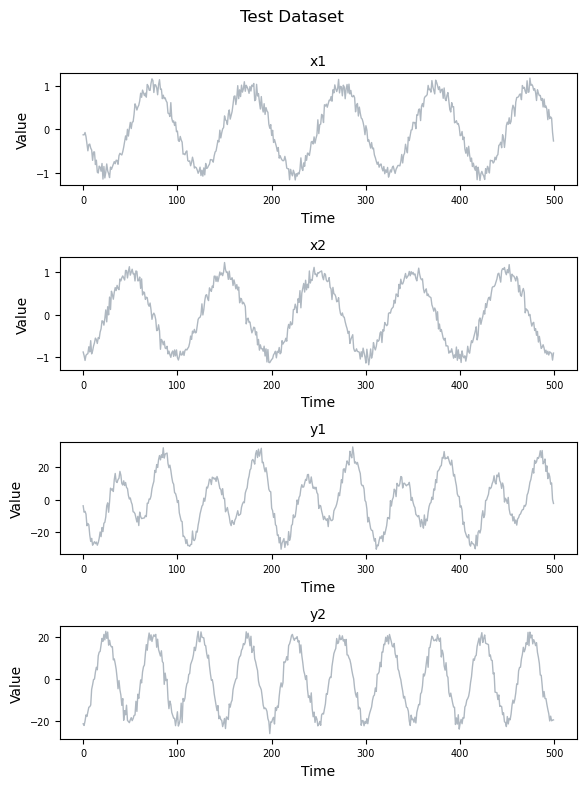

In [28]:
fig, axs = plt.subplots(nrows=len([c for c in test_dataset.columns if c != "ts"]), ncols=1, sharex=True, figsize=(6, 8))
for i, c in enumerate([c for c in test_dataset.columns if c != "ts"]):
    axs[i].plot(test_dataset[c], color="#AFB8C1", lw=1)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

In [29]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False),
    bucket=bucket,
    key="data/inference/input/test.csv"
)

In [30]:
test_data

's3://sagemaker-eu-west-1-661670223746/data/inference/input/test.csv'

In [31]:
payload = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix="data/inference/input/test.csv"
)

### C. Perform real-time inference

In [32]:
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload
)

real_time_predictions = response["Body"].read().decode("utf-8").split("\n")[:-1]
real_time_predictions = pd.DataFrame([x.split(",") for x in real_time_predictions[1:]], columns=real_time_predictions[0].split(",")).replace("", np.nan).astype(float)

In [33]:
response

{'ResponseMetadata': {'RequestId': 'd7f25147-e7f2-4294-af0a-89a4117a5733',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd7f25147-e7f2-4294-af0a-89a4117a5733',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Thu, 07 Sep 2023 13:19:53 GMT',
   'content-type': 'application/json',
   'content-length': '19220',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7fe7983ccc70>}

In [34]:
real_time_results = sagemaker_session.upload_string_as_file_body(
    body=real_time_predictions.to_csv(index=False),
    bucket=bucket,
    key="data/inference/output/real-time/real_time_predictions.csv"
)

In [35]:
real_time_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/real-time/real_time_predictions.csv'

### D. Visualize output

The inference algorithm outputs the predicted values of the time series. 

**Notes:** 

a) The model predicts the time series sequence by sequence. For instance, if the `context-length` is set equal to 200, and the `prediction-length` is set equal to 100, then the first 200 data points (from 1 to 200) are used as input to predict the next 100 data points (from 201 to 300). As a result, the algorithm does not return the predicted values of the first 200 data points, which are set to missing in the output CSV file.

b) The outputs include the out-of-sample forecasts beyond the last time step of the inputs. For instance, if the number of input samples is 500, and the `prediction-length` is 100, then the output CSV file will contain 600 samples, where the last 100 samples are the out-of-sample forecasts.  

In [36]:
real_time_predictions.shape

(600, 2)

In [37]:
real_time_predictions.head()

,y1,y2
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [38]:
real_time_predictions.tail()

,y1,y2
595,11.210664,-15.469055
596,8.147223,-18.012350
597,4.958166,-18.197933
598,4.018135,-20.842334
599,-0.233299,-20.634953


In [39]:
real_time_predictions.isna().sum(axis=0)

y1    100
y2    100
dtype: int64

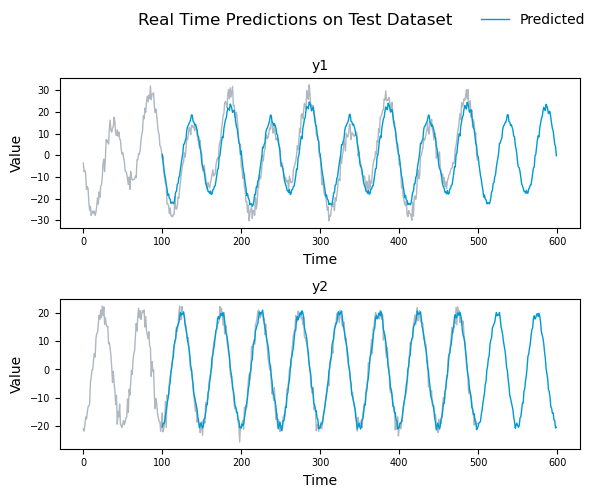

In [40]:
fig, axs = plt.subplots(nrows=len([c for c in test_dataset.columns if c.startswith("y")]), ncols=1, sharex=True, figsize=(6, 5))
for i, c in enumerate([c for c in test_dataset.columns if c.startswith("y")]):
    axs[i].plot(test_dataset[c], color="#AFB8C1", lw=1)
    axs[i].plot(real_time_predictions[c], color="#009ad3", lw=1, label="Predicted" if i == 0 else None)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Real Time Predictions on Test Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.show()

### E. Calculate relevant metrics

In this section we assess the model's forecasting performance against the ground truth time series values. Note that in this section we calculate the mean squared error (MSE) and mean absolute error (MAE) separately for each time series using unscaled data. These are different from the metrics returned by the algorithm, which are the average MSE and MAE across all time series calculated using scaled data.   

In [41]:
for c in [c for c in test_dataset.columns if c.startswith("y")]:
    mse = mean_squared_error(test_dataset[c].iloc[context_length:], real_time_predictions[c].iloc[context_length: - prediction_length])
    mae = mean_absolute_error(test_dataset[c].iloc[context_length:], real_time_predictions[c].iloc[context_length: -prediction_length])
    print(f"Time series: {c}, MSE: {format(mse, '.2f')}, MAE: {format(mae, '.2f')}")

Time series: y1, MSE: 26.89, MAE: 4.40
Time series: y2, MSE: 4.66, MAE: 1.73


If [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) supports the type of problem you are trying to solve using this algorithm, use the following examples to add Model Monitor support to your product.
For sample code to enable and monitor the model, see following notebooks:
1. [Enable Amazon SageMaker Model Monitor](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/enable_model_monitor/SageMaker-Enable-Model-Monitor.ipynb)
2. [Amazon SageMaker Model Monitor - visualizing monitoring results](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb)

### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the same to avoid being charged.

In [42]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: cfc-tsf-endpoint-2023-09-07-13-14-00-671388
INFO:sagemaker:Deleting endpoint with name: cfc-tsf-endpoint-2023-09-07-13-14-00-671388


Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

## 5: Tune your model! (optional)

### A. Tuning Guidelines

The model has the following hyperparameters, all of which are tunable:
- `context-length`: `int`. The length of the input sequences.
- `prediction-length`: `int`. The length of the output sequences.
- `backbone-layers`: `int`. The number of hidden layers of the backbone neural network. 
- `backbone-units`: `int`. The number of hidden units of the backbone neural network.
- `backbone-activation`: `str`. The activation function of the backbone neural network.
- `backbone-dropout`: `float`. The dropout rate of the backbone neural network.
- `hidden-size`: `int`. The number of hidden units of the neural network heads.
- `minimal`: `bool`. If set to 1, the model will use the CfC direct solution.
- `no-gate`: `bool`. If set to 1, the model will use a CfC without the (1 - sigmoid) part.
- `use-ltc`: `bool`. If set to 1, the model will use an LTC instead of a CfC.
- `use-mixed`: `bool`. If set to 1, the model will mix the CfC RNN-state with an LSTM.
- `lr`: `float`. The learning rate used for training.
- `lr-decay`: `float`. The decay factor applied to the learning rate.
- `batch-size`: `int`. The batch size used for training.
- `epochs`: `int`. The number of training epochs.

### B. Define Tuning configuration

In [43]:
hyperparameter_ranges = {
    "backbone-layers": sagemaker.parameter.IntegerParameter(1, 3),
    "backbone-units": sagemaker.parameter.CategoricalParameter([32, 64, 128, 256]),
    "backbone-activation": sagemaker.parameter.CategoricalParameter(["silu", "relu", "tanh", "gelu", "lecun"]),
    "backbone-dropout": sagemaker.parameter.ContinuousParameter(0, 0.5),
    "hidden-size": sagemaker.parameter.CategoricalParameter([32, 64, 128, 256]),
    "lr": sagemaker.parameter.ContinuousParameter(0.0001, 0.01),
    "lr-decay": sagemaker.parameter.ContinuousParameter(0.1, 0.9),
    "batch-size": sagemaker.parameter.CategoricalParameter([32, 64, 128, 256]),
    "epochs": sagemaker.parameter.IntegerParameter(20, 200),
}

We use the validation mean absolute error (MAE) as the objective to be minimized.

In [44]:
objective_metric_name = "valid_mae"

In [45]:
objective_type = "Minimize"

### C. Run a model tuning job

Make sure to detach the pre-trained model before tuning, otherwise the algorithm will keep using the same hyperparameters with the exception of the batch size, learning rate decay factor and number of epochs.

In [46]:
estimator.model_uri = None

In the interest of time, we run the tuner only for a few iterations. 

In [47]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="cfc-tsf-tuning",
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=4,
    random_seed=100,
)

In [48]:
tuner.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating hyperparameter tuning job with name: cfc-tsf-tuning-230907-1319


.....................................................................................................................................................................................................................................................!


In [49]:
tuner.analytics().dataframe().sort_values(by="FinalObjectiveValue", ascending=True, ignore_index=True)

,backbone-activation,backbone-dropout,backbone-layers,backbone-units,batch-size,epochs,hidden-size,lr,lr-decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,gelu,0.295607,1.0,64.0,64.0,197.0,32.0,0.006777,0.725963,cfc-tsf-tuning-230907-1319-003-5e6b8d09,Completed,0.147326,2023-09-07 13:21:06+00:00,2023-09-07 13:35:11+00:00,845.0
1,tanh,0.410043,1.0,256.0,128.0,194.0,32.0,0.001237,0.695482,cfc-tsf-tuning-230907-1319-002-069ba7ac,Completed,0.565430,2023-09-07 13:21:10+00:00,2023-09-07 13:30:54+00:00,584.0
2,lecun,0.494782,3.0,32.0,32.0,122.0,32.0,0.000346,0.711703,cfc-tsf-tuning-230907-1319-004-7927752d,Completed,0.677418,2023-09-07 13:21:15+00:00,2023-09-07 13:38:01+00:00,1006.0
3,relu,0.124774,1.0,64.0,32.0,52.0,64.0,0.000195,0.155700,cfc-tsf-tuning-230907-1319-001-44e4a763,Completed,0.867866,2023-09-07 13:21:01+00:00,2023-09-07 13:28:34+00:00,453.0


In [50]:
tuning_job_result = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

In [51]:
print("Best hyperparameters:")
tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

Best hyperparameters:


{'backbone-activation': 'gelu',
 'backbone-dropout': '0.2956067352669055',
 'backbone-layers': '1',
 'backbone-units': '64',
 'batch-size': '64',
 'epochs': '197',
 'hidden-size': '32',
 'lr': '0.006776639721916928',
 'lr-decay': '0.7259629710229953'}

In [52]:
print("Best score:")
tuning_job_result["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

Best score:


0.14732575416564941

Once you have completed a tuning job (or even while the job is still running), you can [clone and use this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to analyze the results to understand how each hyperparameter effects the quality of the model.

## 6. Perform Batch inference

In this section, you will perform batch inference.

In [53]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: cfc-tsf-algo-v1-1-2023-09-07-13-40-54-645


.........

INFO:sagemaker:Creating model with name: cfc-tsf-algo-v1-1-2023-09-07-13-40-54-6-2023-09-07-13-41-40-200


In [54]:
transformer.base_transform_job_name = "cfc-tsf-transform"

In [55]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: cfc-tsf-transform-2023-09-07-13-41-41-164


2023-09-07T13:48:58,237 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-07T13:48:58,308 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-07T13:48:58,412 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
2023-09-07T13:48:58,237 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-07T13:48:58,308 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-07T13:48:58,412 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-s

In [56]:
batch_predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test.csv.out"
)

batch_predictions = batch_predictions.split("\n")[:-1]
batch_predictions = pd.DataFrame([x.split(",") for x in batch_predictions[1:]], columns=batch_predictions[0].split(",")).replace("", np.nan).astype(float)

In [57]:
batch_predictions.head()

,y1,y2
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [58]:
batch_predictions.tail()

,y1,y2
595,11.210664,-15.469055
596,8.147223,-18.012350
597,4.958166,-18.197933
598,4.018135,-20.842334
599,-0.233299,-20.634953


In [59]:
batch_predictions.isna().sum(axis=0)

y1    100
y2    100
dtype: int64

In [60]:
np.all(np.isclose(batch_predictions.dropna().values, real_time_predictions.dropna().values))

True

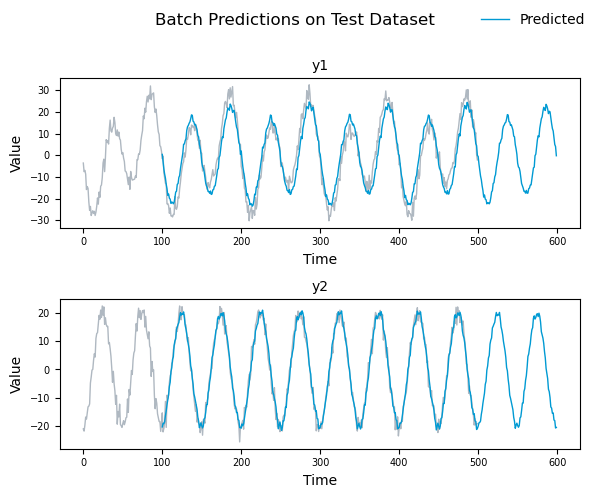

In [61]:
fig, axs = plt.subplots(nrows=len([c for c in test_dataset.columns if c.startswith("y")]), ncols=1, sharex=True, figsize=(6, 5))
for i, c in enumerate([c for c in test_dataset.columns if c.startswith("y")]):
    axs[i].plot(test_dataset[c], color="#AFB8C1", lw=1)
    axs[i].plot(batch_predictions[c], color="#009ad3", lw=1, label="Predicted" if i == 0 else None)
    axs[i].set_title(c, size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Batch Predictions on Test Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.show()

In [62]:
batch_results = sagemaker_session.upload_string_as_file_body(
    body=batch_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/batch/batch_predictions.csv"
)

In [63]:
batch_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/batch/batch_predictions.csv'

## 7. Clean-up

### A. Delete the model

In [64]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: cfc-tsf-algo-v1-1-2023-09-07-13-40-54-6-2023-09-07-13-41-40-200


### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

